In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# %matplotlib notebook
%matplotlib inline

In [2]:
import cached

from importlib import reload

reload(cached)

sim = cached.sim

In [3]:
def set_seed(i):
    random.seed(i)
    np.random.seed(random.getrandbits(32))

In [4]:
def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

compute 7 [0.03571429 0.07142857 0.10714286 0.14285714 0.17857143 0.21428571
 0.25      ]


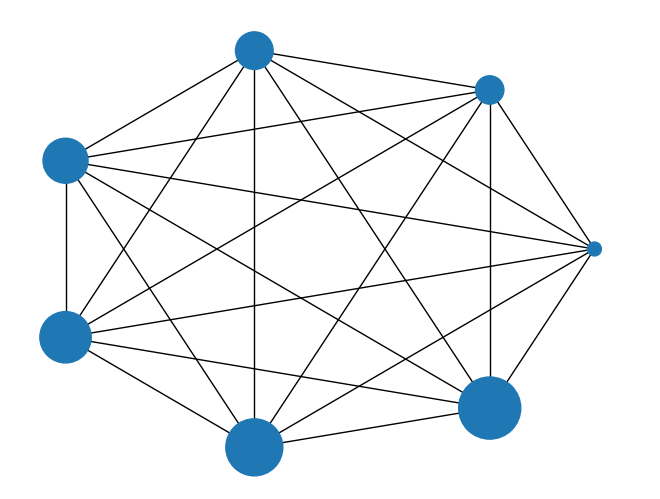

In [5]:
# Mining statistics for the last 7 days before Dec. 12 2022
# from https://www.blockchain.com/explorer/charts/pools
compute = [  # relative hash-rate # blocks mined / pool
    0.24817,  # 271 / Foundry USA
    0.20147,  # 220 / AntPool
    0.15110,  # 165 / F2Pool
    0.13736,  # 150 / Binance Pool
    0.10440,  # 114 / ViaBTC
    0.05311,  # 58  / Braiins Pool
    0.02473,  # 27  / Poolin
    0.01923,  # 21  / BTC.com
    0.01648,  # 18  / Luxor
    0.01465,  # 16  / Mara Pool
    0.00641,  # 7   / Ultimus
    0.00641,  # 7   / SBI Crypto
    0.00366,  # 4   / BTC M4
    0.00275,  # 3   / Titan
    # NaN    # 11  / Unknown
]
assert np.sum(compute) < 1
compute.append(1 - np.sum(compute))

compute = list(range(1, 8))

# compute = [ 0.01, 0.99 ]

compute = compute / np.sum(compute)
print("compute", len(compute), compute)

G = nx.complete_graph(len(compute))
G.graph["dissemination"] = "simple"

for i in range(len(compute)):
    G.nodes[i]["compute"] = compute[i]

for a, b in G.edges:
    # G.edges[a, b]["delay"] = f"uniform 0.5 1.5"
    G.edges[a, b]["delay"] = f"constant 1"

layout = nx.circular_layout(G)
draw(G, layout=layout)
# print_(G)

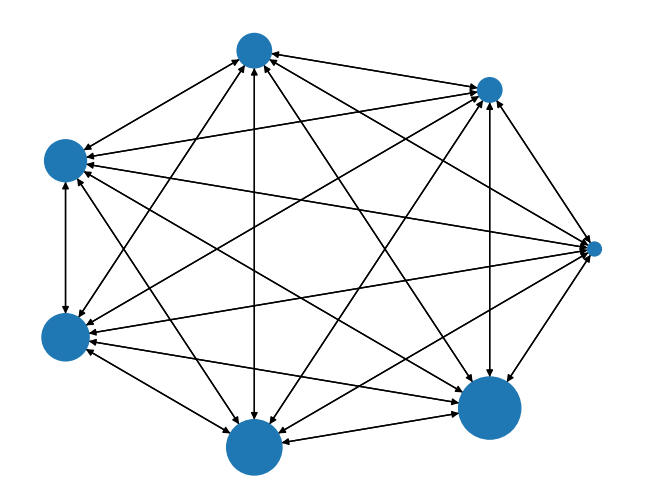

In [6]:
res = sim(G, activation_delay=1, activations=10000, protocol="nakamoto")
draw(res, size="reward", layout=layout)

In [7]:
# copied from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [8]:
def subblock_selection(x):
    if x.k <= 32:
        return "heuristic"
    else:
        return "altruistic"


families = dict(
    nakamoto=lambda x: "nakamoto",
    bk=lambda x: f"bk-{x.k}-constant",
    bkll=lambda x: f"bkll-{x.k}-constant",
    tailstorm=lambda x: f"tailstorm-{x.k}-{x.scheme}-{subblock_selection(x)}",
    tailstormll=lambda x: f"tailstormll-{x.k}-{x.scheme}-{subblock_selection(x)}",
)

ks = dict(
    nakamoto=[1],
    bk=[2, 4, 8, 16, 32, 64, 128],
    bkll=[2, 4, 8, 16, 32, 64, 128],
    tailstorm=[2, 4, 8, 16, 32, 64, 128],
    tailstormll=[2, 4, 8, 16, 32, 64, 128],
)

schemes = dict(
    nakamoto=["constant"],
    bk=["constant"],
    bkll=["constant"],
    tailstorm=["constant", "discount"],
    tailstormll=["constant", "discount"],
)

block_intervals = [
    1,
    2,
    4,
    8,
    16,
    32,
    64,
    128,
]  # nakamoto/tailstorm/bk blocks, tailstorm summaries (multiples of expected message delay)


def rows():
    for i in range(256):
        for f in families.keys():
            for s in schemes[f]:
                for k in ks[f]:
                    for bi in block_intervals:
                        ad = bi / k  # activation delay
                        if ad >= 1:
                            yield pd.Series(
                                dict(
                                    family=f,
                                    k=k,
                                    scheme=s,
                                    protocol=f"{f}-{k}-{s}",
                                    block_interval=bi,
                                    activation_delay=ad,
                                    seed=i,
                                    activations=1024,
                                    # activations= k * 128, # enough pow for 128 blocks
                                )
                            )


def read(G, field):
    return np.array([G.nodes[i][field] for i in range(len(compute))])


def measure(x):
    res = sim(
        G,
        activation_delay=x.activation_delay,
        activations=x.activations,
        protocol=families[x.family](x),
        seed=x.seed,
    )
    reward = read(res, "reward")
    activations = read(res, "activations")
    assert sum(activations) == x.activations
    compute = read(res, "compute")
    compute = compute / np.sum(compute)
    relrew = reward / np.sum(reward)
    relrewn = relrew / compute
    efficiency0 = reward / compute
    with np.errstate(divide="ignore", invalid="ignore"):
        efficiency1 = np.where(activations > 0, reward / activations, 0.0)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    return pd.Series(
        dict(
            chain_time=res.graph["chain_time"],
            progress=res.graph["progress"],
            height=res.graph["progress"] / x.k,
            reward=np.sum(reward),
            revenue_loss=1 - (np.sum(reward) / np.sum(activations)),
            weakest_reward=reward[weakest],
            weakest_relrew=relrew[weakest],
            weakest_relrewn=relrewn[weakest],
            weakest_efficiency0=efficiency0[weakest],
            weakest_efficiency1=efficiency1[weakest],
            strongest_reward=reward[strongest],
            strongest_relrew=relrew[strongest],
            strongest_relrewn=relrewn[strongest],
            strongest_efficiency0=efficiency0[strongest],
            strongest_efficiency1=efficiency1[strongest],
            diff_reward=reward[strongest] - reward[weakest],
            diff_relrew=relrew[strongest] - relrew[weakest],
            diff_relrewn=relrewn[strongest] - relrewn[weakest],
            diff_efficiency0=efficiency0[strongest] - efficiency0[weakest],
            diff_efficiency1=efficiency1[strongest] - efficiency1[weakest],
            gini_reward=gini(reward),
            gini_relrew=gini(relrew),
            gini_relrewn=gini(relrewn),
            gini_efficiency0=gini(efficiency0),
            gini_efficiency1=gini(efficiency1),
        )
    )


def parallel_measure(df, fun=measure, n_jobs=-1):
    res = Parallel(n_jobs=n_jobs)(
        delayed(measure)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


df = pd.DataFrame(rows())
df = parallel_measure(df)
df

  0%|          | 0/45056 [00:00<?, ?it/s]

,family,k,scheme,protocol,block_interval,activation_delay,seed,activations,chain_time,progress,...,diff_reward,diff_relrew,diff_relrewn,diff_efficiency0,diff_efficiency1,gini_reward,gini_relrew,gini_relrewn,gini_efficiency0,gini_efficiency1
0,nakamoto,1,constant,nakamoto-1-constant,1,1.0,0,1024,1055.274402,631.0,...,166.000000,0.263074,0.786054,496.00000,0.497319,0.374915,0.374915,0.177938,0.177938,0.145181
1,nakamoto,1,constant,nakamoto-1-constant,2,2.0,0,1024,2110.548805,770.0,...,184.000000,0.238961,0.363636,280.00000,0.292042,0.339147,0.339147,0.092320,0.092320,0.065186
2,nakamoto,1,constant,nakamoto-1-constant,4,4.0,0,1024,4221.097609,872.0,...,195.000000,0.223624,0.178899,156.00000,0.174281,0.321429,0.321429,0.070773,0.070773,0.031246
3,nakamoto,1,constant,nakamoto-1-constant,8,8.0,0,1024,8442.195219,935.0,...,205.000000,0.219251,0.106952,100.00000,0.121729,0.316272,0.316272,0.063819,0.063819,0.022430
4,nakamoto,1,constant,nakamoto-1-constant,16,16.0,0,1024,16884.390437,980.0,...,211.000000,0.215306,0.053061,52.00000,0.076362,0.312828,0.312828,0.060043,0.060043,0.013554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45051,tailstormll,32,discount,tailstormll-32-discount,64,2.0,255,1024,1977.323229,992.0,...,164.781250,0.223888,-0.082711,-60.87500,0.009808,0.286891,0.286891,0.036631,0.036631,0.005353
45052,tailstormll,32,discount,tailstormll-32-discount,128,4.0,255,1024,3912.043814,992.0,...,185.875000,0.221808,-0.106205,-89.00000,-0.005958,0.285235,0.285235,0.037916,0.037916,0.005632
45053,tailstormll,64,discount,tailstormll-64-discount,64,1.0,255,1024,950.438384,960.0,...,131.453125,0.225477,-0.043632,-25.43750,0.027184,0.288647,0.288647,0.033287,0.033287,0.013573
45054,tailstormll,64,discount,tailstormll-64-discount,128,2.0,255,1024,1885.558166,960.0,...,158.312500,0.225196,-0.070590,-49.62500,0.016841,0.288807,0.288807,0.033575,0.033575,0.012457


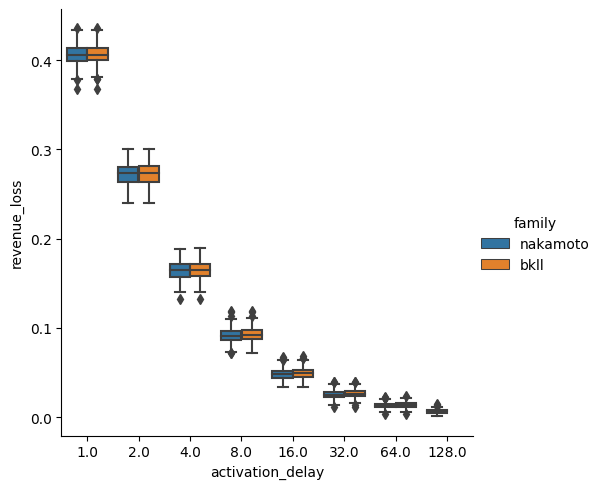

In [9]:
# check: nakamoto = bk_ll 2
ax = sns.catplot(
    data=df.query('family in ["nakamoto", "bkll"] and k in [1, 2]'),
    y="revenue_loss",
    x="activation_delay",
    hue="family",
    kind="box",
)

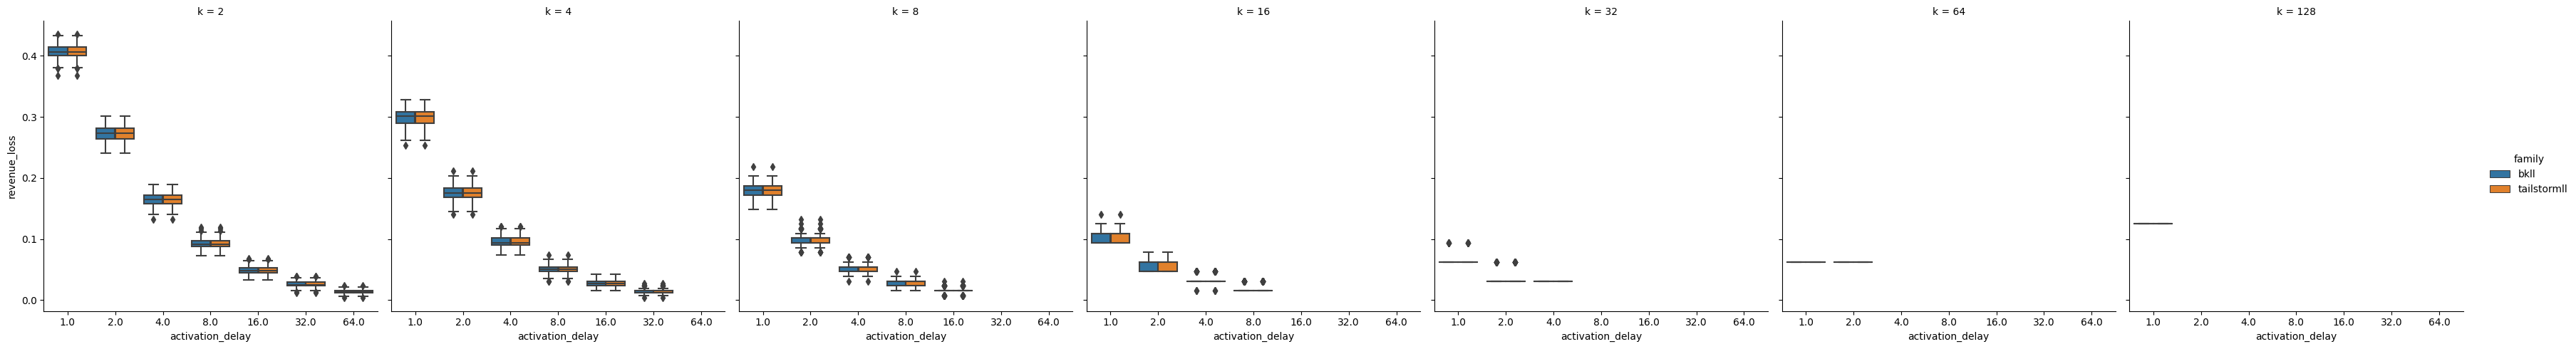

In [10]:
# check: bk_ll = tailstorm_ll constant
ax = sns.catplot(
    kind="box",
    data=df.query('family in ["bkll", "tailstormll"] and scheme == "constant"'),
    y="revenue_loss",
    x="activation_delay",
    hue="family",
    col="k",
)

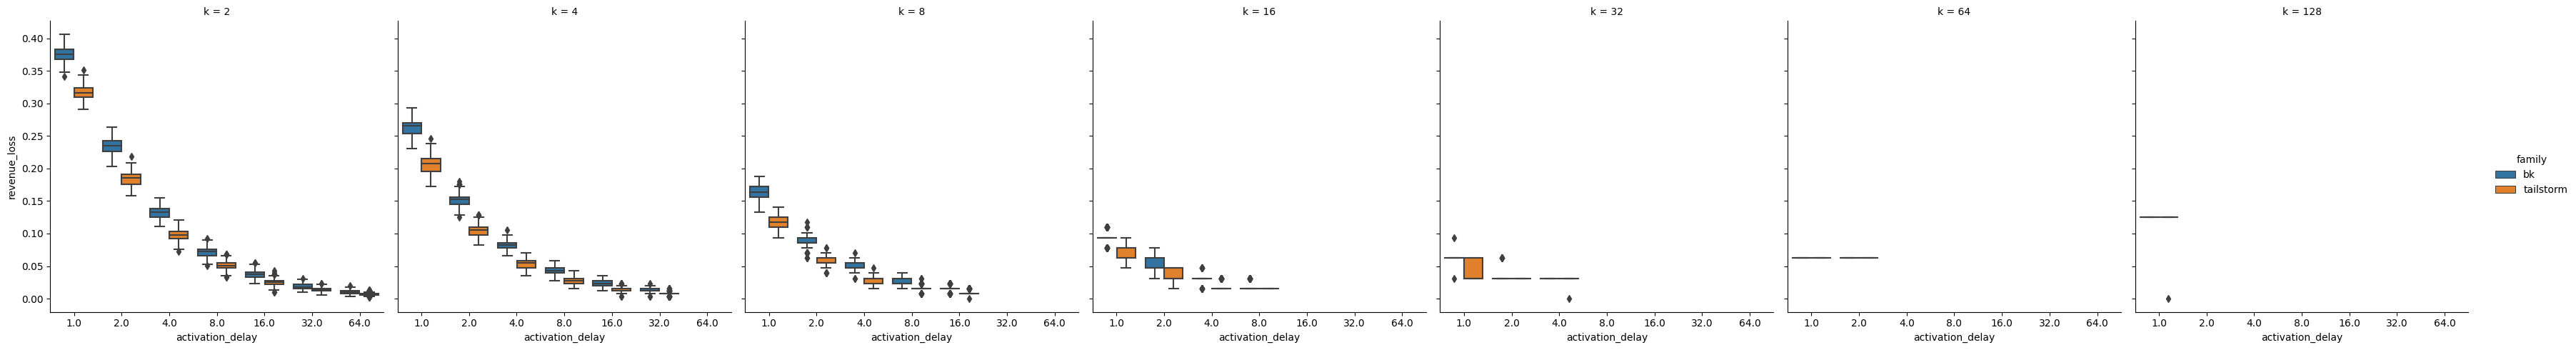

In [11]:
# check: bk != tailstorm constant
ax = sns.catplot(
    kind="box",
    data=df.query('family in ["bk", "tailstorm"] and scheme == "constant"'),
    y="revenue_loss",
    x="activation_delay",
    hue="family",
    col="k",
)

In [12]:
df = df.query('not (family == "tailstormll")')  # redundant with bkll
df = df.query('not (family == "bkll" and k == 2)')  # redundant with nakamoto

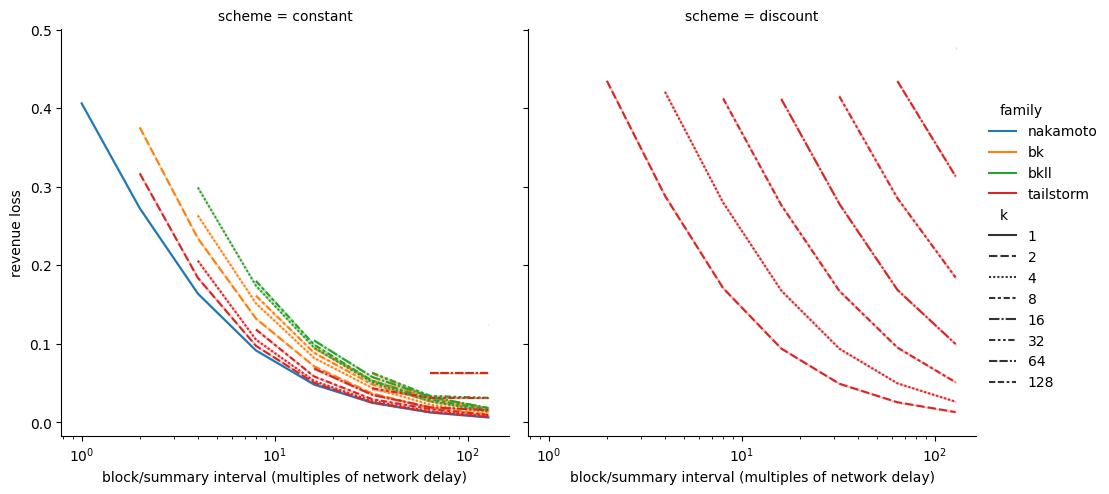

In [13]:
ax = sns.relplot(
    kind="line",
    data=df,
    hue="family",
    style="k",
    y="revenue_loss",
    x="block_interval",
    col="scheme",
)

ax.set(
    xscale="log",
    xlabel="block/summary interval (multiples of network delay)",
    ylabel="revenue loss",
)

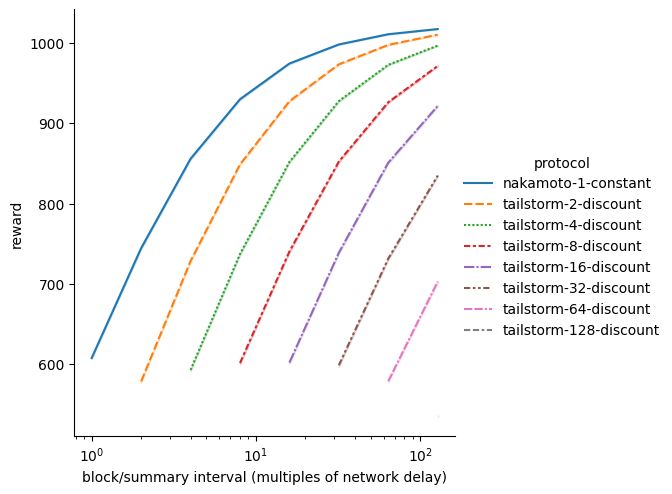

In [14]:
ax = sns.relplot(
    kind="line",
    data=df.query(
        "family == 'nakamoto' or (family == 'tailstorm' and scheme == 'discount')"
    ),
    hue="protocol",
    style="protocol",
    y="reward",
    x="block_interval",
)

ax.set(
    xscale="log",
    xlabel="block/summary interval (multiples of network delay)",
    ylabel="reward",
)

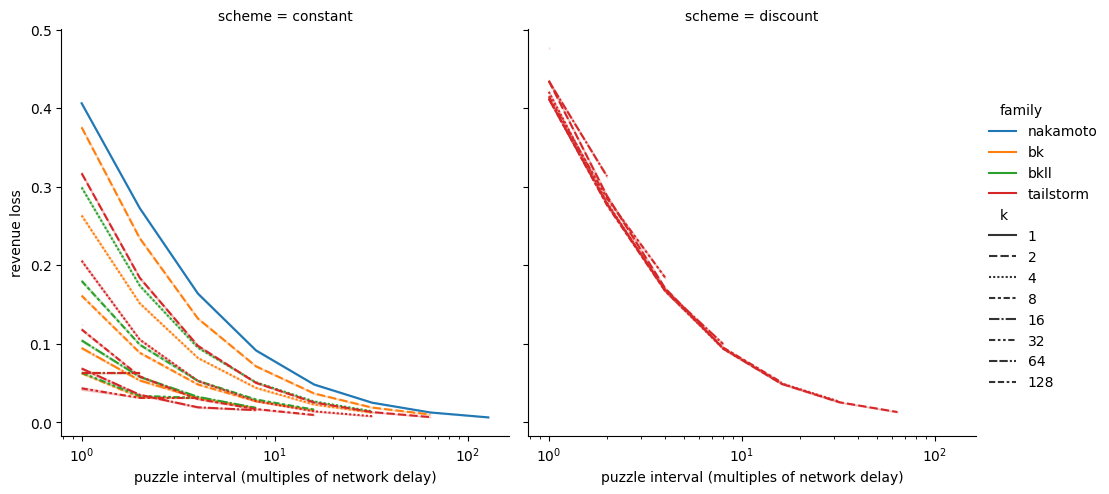

In [15]:
ax = sns.relplot(
    kind="line",
    data=df,
    hue="family",
    style="k",
    y="revenue_loss",
    x="activation_delay",
    col="scheme",
)

ax.set(
    xscale="log",
    xlabel="puzzle interval (multiples of network delay)",
    ylabel="revenue loss",
)

In [16]:
key = ["family", "k", "activation_delay", "block_interval"]
a = (
    df.query('scheme == "constant" and k in [1, 8]')
    .groupby(key)
    .agg(
        orphan_rate=("revenue_loss", np.mean),
        gini_constant=("gini_efficiency1", np.mean),
    )
)
b = (
    df.query('scheme != "constant" and k in [1, 8]')
    .groupby(key)
    .agg(
        revenue_loss=("revenue_loss", np.mean),
        gini_discount=("gini_efficiency1", np.mean),
    )
)
c = a.join(b)
for i, x in c.iterrows():
    if np.isnan(x.revenue_loss):
        c.loc[i]["revenue_loss"] = c.loc[i].orphan_rate
c.reset_index().sort_values(["block_interval", "family"])

,family,k,activation_delay,block_interval,orphan_rate,gini_constant,revenue_loss,gini_discount
10,nakamoto,1,1.0,1,0.406284,0.107415,0.406284,NaN
11,nakamoto,1,2.0,2,0.272770,0.056873,0.272770,NaN
12,nakamoto,1,4.0,4,0.164104,0.031455,0.164104,NaN
0,bk,8,1.0,8,0.161346,0.026266,0.161346,NaN
5,bkll,8,1.0,8,0.180084,0.032450,0.180084,NaN
13,nakamoto,1,8.0,8,0.091728,0.018855,0.091728,NaN
18,tailstorm,8,1.0,8,0.118378,0.022538,0.412464,0.031814
1,bk,8,2.0,16,0.088745,0.016654,0.088745,NaN
6,bkll,8,2.0,16,0.099060,0.019933,0.099060,NaN
14,nakamoto,1,16.0,16,0.048321,0.012238,0.048321,NaN


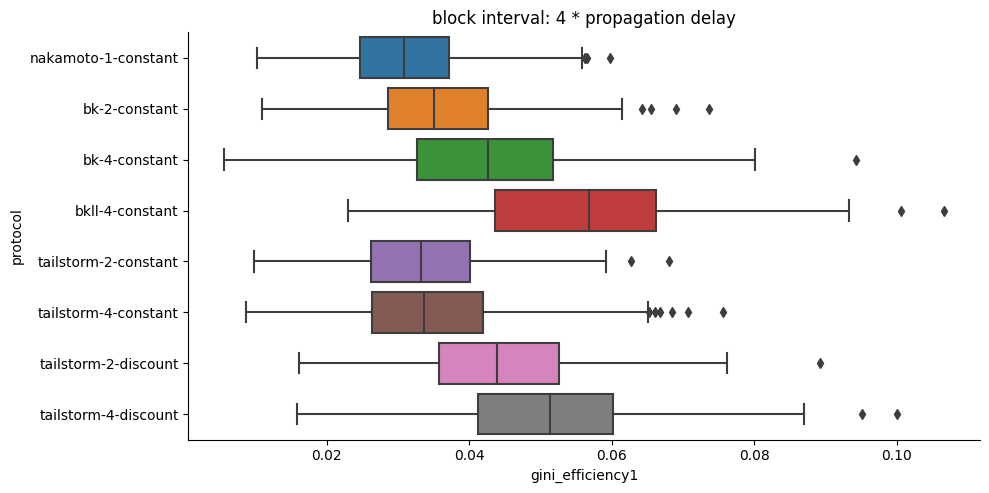

In [17]:
def bp_bi(metric, bi=32):
    plt = sns.catplot(
        data=df.query(f"block_interval == {bi}"),
        x=metric,
        y="protocol",
        kind="box",
        aspect=2,
        row="block_interval",
    )
    plt.set(title=f"block interval: {bi} * propagation delay")


def bp_ad(metric, ad=4):
    plt = sns.catplot(
        data=df.query(f"activation_delay == {ad}"),
        x=metric,
        y="protocol",
        kind="box",
        aspect=2,
    )
    plt.set(title=f"activation delay: {ad} * propagation delay")


bp_bi("gini_efficiency1", bi=4)

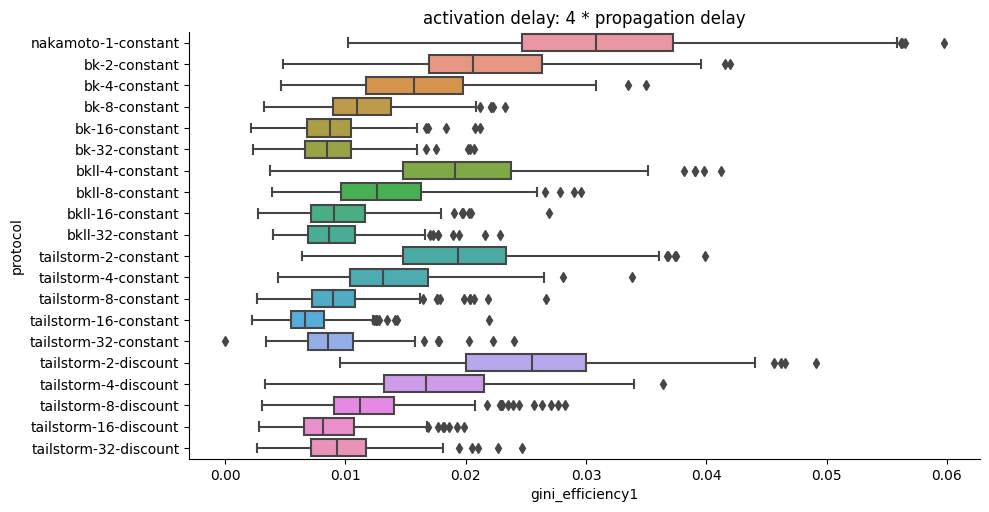

In [18]:
bp_ad("gini_efficiency1", ad=4)

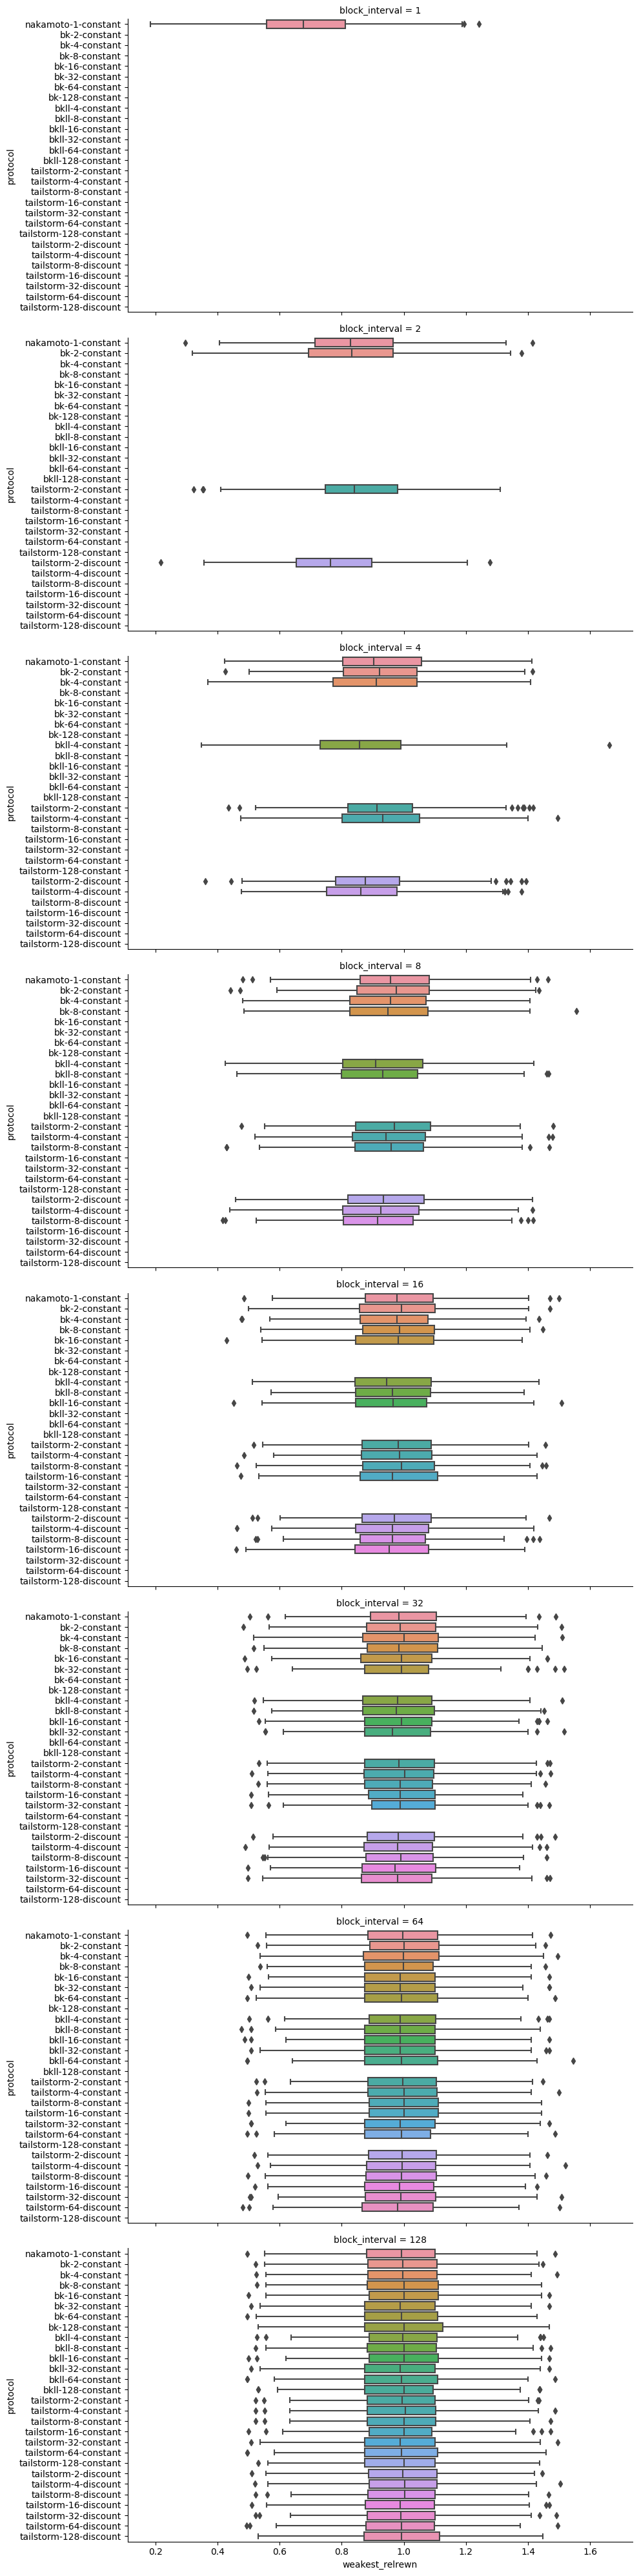

In [19]:
plt = sns.catplot(
    data=df,
    # x="gini_efficiency1",
    x="weakest_relrewn",
    # x="strongest_relrewn",
    y="protocol",
    kind="box",
    aspect=2,
    row="block_interval",
)